<a href="https://colab.research.google.com/github/allexanderprastya/PROJECT-TA-JURNAL/blob/main/IndoBERT_Base_32_Batch_LR2e_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

In [2]:
!nvidia-smi

Wed Nov  9 14:38:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Google Play App Sentiment Analysis 

### Importing Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid',font_scale= 1.2)
sns.set_palette(sns.color_palette("bright"))

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import AutoModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict
from textwrap import wrap

In [4]:
print(torch.__version__)

1.12.1+cu113


In [5]:
print(transformers.__version__)

4.24.0


In [6]:
# Let's start by defining some key variables that will be used later on in the training/evaluation process
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 5
# Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.
# Set seed for reproducibility.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the Dataset

In [7]:
df_reviews = pd.read_csv("/content/labelTextBlob_no_stemming.csv")
df_reviews.head()

,content,polarity,label
0,bangkai turun knock langsung tolong tencent sa...,-0.200000,negative
1,mangapa pubg loading login kuota beli,0.000000,neutral
2,bug developer perbaiki mengeluh bug lag,0.000000,neutral
3,berat putar enak mainnya bagus,0.400000,positive
4,game bagus sayang sinyal turun gameplay sulit ...,-0.206173,negative


In [8]:
# lets check the shape of reviews dataframe
df_reviews.shape

(14341, 3)

We have about 15k examples. Let's check for missing values-

In [9]:
df_reviews.isnull().sum()

content     0
polarity    0
label       0
dtype: int64

In [10]:
df_reviews['content'].describe()

count     14341
unique     7173
top       bagus
freq        446
Name: content, dtype: object

**Great, no missing values in the score and review texts! Do we have class imbalance?**

In [11]:
# helper function to draw percentage above each bar
def draw_percentage(ax,total=float(len(df_reviews))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

**That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment.**

In [12]:
def to_sentiment(rating):
  rating = float(rating)
  if rating <0 :
    return 0
  elif rating == 0:
    return 1
  else:
    return 2

df_reviews['sentiment'] = df_reviews.polarity.apply(to_sentiment)

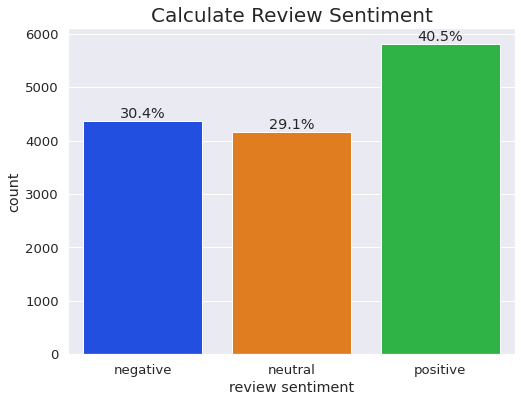

In [13]:
class_names = ['negative', 'neutral', 'positive']

plt.figure(figsize = (8,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'sentiment',
                   data = df_reviews
                   )
ax.set_xticklabels(class_names)
plt.title('Calculate Review Sentiment',
          fontsize=20
          )
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

In [14]:
# Word cloud 
def wordCloud(sentiment):
    data = df_reviews[df_reviews['sentiment'] == sentiment]
    text = " ".join(review for review in data.content)
    wordcloud = WordCloud(background_color='white',height = 600, width = 800, max_font_size=200).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

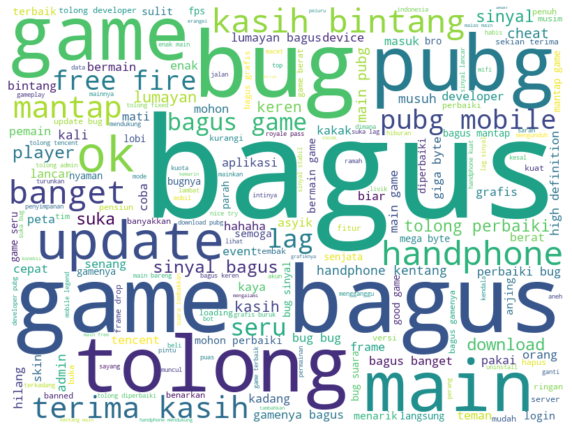

In [15]:
# most positive words
wordCloud(2)

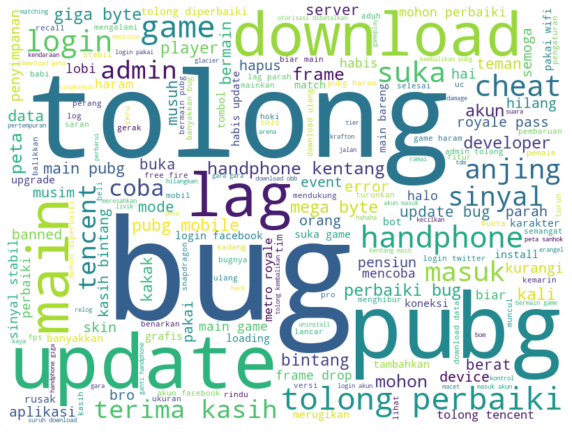

In [16]:
# most neutral words
wordCloud(1)

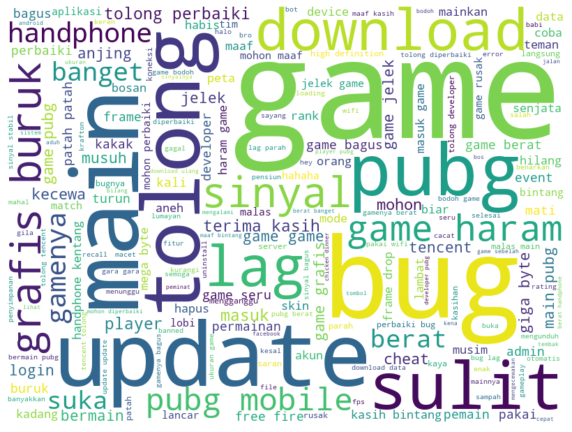

In [17]:
# most negative words
wordCloud(0)

### Data Preprocessing

In [18]:
# Saya menggunakan versi BERT tokenizer dari Indobenchmark (https://huggingface.co/indobenchmark/indobert-base-p1)
PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p2'

# Saya memuat BertTokenizer yang telah dilatih sebelumnya
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
sample_txt = "game bagus sayang sinyal turun gameplay sulit main mati frame mati sulit download peta update kouta boros berat game"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: game bagus sayang sinyal turun gameplay sulit main mati frame mati sulit download peta update kouta boros berat game
   Tokens: ['game', 'bagus', 'sayang', 'sinyal', 'turun', 'game', '##play', 'sulit', 'main', 'mati', 'frame', 'mati', 'sulit', 'download', 'peta', 'update', 'ko', '##uta', 'boros', 'berat', 'game']
Token IDs: [2010, 1305, 3067, 5711, 2061, 2010, 8907, 1899, 2724, 1861, 11795, 1861, 1899, 1974, 2577, 4398, 1455, 1257, 15516, 1396, 2010]


In [20]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [21]:
# pengkodean kalimat
encoding = tokenizer.encode_plus(sample_txt,
                                 max_length=32,
                                 truncation=True,  #Potong kalimat menjadi panjang maksimum.
                                 add_special_tokens=True, # menambahkan '[CLS]' dan '[SEP]'
                                 return_token_type_ids=False,
                                 padding='max_length', # Pad kalimat dengan panjang maksimum '[PAD]'.
                                 return_attention_mask=True, # Kembali attention mask
                                 return_tensors='pt'  # Kembali torch objects
                                 )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

ID token sekarang disimpan di tensorflow tensor dan diisi dengan panjang 32.

In [22]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

32
tensor([    2,  2010,  1305,  3067,  5711,  2061,  2010,  8907,  1899,  2724,
         1861, 11795,  1861,  1899,  1974,  2577,  4398,  1455,  1257, 15516,
         1396,  2010,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


In [23]:
# Attention mask memiliki panjang yang sama
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

32
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [24]:
#membalikkan tokenisasi untuk melihat token khusus
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'game',
 'bagus',
 'sayang',
 'sinyal',
 'turun',
 'game',
 '##play',
 'sulit',
 'main',
 'mati',
 'frame',
 'mati',
 'sulit',
 'download',
 'peta',
 'update',
 'ko',
 '##uta',
 'boros',
 'berat',
 'game',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Memilih Panjang Urutan

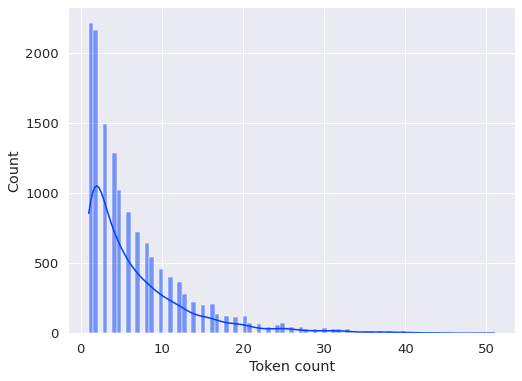

In [28]:
#Saya akan menggunakan strategi sederhana untuk memilih panjang maksimal yaitu simpan panjang token setiap review.
seq_len = [len(i.split()) for i in df_reviews.content]

plt.figure(figsize = (8,6))
sns.histplot(data = seq_len,
             kde=True
             )
plt.xlabel('Token count')
plt.show()

Sebagian besar ulasan tampaknya berisi kurang dari 80 token, tetapi saya menggunakan panjang maksimum 100 untuk amannya.

In [29]:
MAX_LEN = 60

Sekarang setelah data telah diproses sebelumnya, saya dapat mengubahnya menjadi tensor PyTorch sehingga dapat meneruskannya ke model.

In [30]:
# We have all building blocks required to create a torch dataset.
class dataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews    = reviews
        self.targets    = targets
        self.tokenizer  = tokenizer
        self.max_len    = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        # langkah 1: dapatkan review dan target
        review = str(self.reviews[item])
        target = self.targets[item]

        # langkah 2: menggunakan tokenizer untuk mengkodekan kalimat (termasuk padding/cutting ke panjang maksimal)
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True, # menambahkan '[CLS]' dan '[SEP]'
                                              max_length=self.max_len,
                                              padding='max_length',  # Padding kalimat menjadi panjang maksimum.
                                              truncation=True,    # Potong kalimat menjadi panjang maksimum.
                                              return_token_type_ids=False,
                                              return_attention_mask=True, # Kembali attention mask
                                              return_tensors='pt' # Kembali  torch objects/tensor
                                              )
        return {
            'review_text'   : review,
            'input_ids'     : encoding['input_ids'].flatten(), # Tensor ID token untuk dimasukkan ke dalam model
            'attention_mask': encoding['attention_mask'].flatten(),  #Tensor Index yang menentukan token mana yang harus diperhatikan oleh model
            'targets'       : torch.tensor(target, dtype=torch.long)
            }

Saya perlu membuat beberapa pemuat data. Inilah fungsi pembantu untuk model.

In [31]:
df_reviews = df_reviews[['content','sentiment']]

In [32]:
def create_data_loader(df_reviews, tokenizer, max_len, batch_size):
    ds = dataset(reviews    = df_reviews.content.to_numpy(),
                 targets    = df_reviews.sentiment.to_numpy(),
                 tokenizer  = tokenizer,
                 max_len    = max_len
                 )
    
    return DataLoader(ds,
                      batch_size = batch_size,
                      num_workers=2
                      )

Tokenizer melakukan sebagian besar pekerjaan berat untuk model dan Saya mengembalikan teks ulasan, sehingga akan lebih mudah untuk mengevaluasi prediksi model.

In [33]:
#pisahkan data train, validation dan test (rasio 90:10:20)

df_train, df_test = train_test_split(df_reviews,
                                     test_size=0.1,
                                     random_state=RANDOM_SEED,
                                     stratify=df_reviews['sentiment']
                                     )

df_test, df_val = train_test_split(df_test,
                                   test_size=0.5,
                                   random_state=RANDOM_SEED,
                                   stratify=df_test['sentiment']
                                   )

print('Train data size', df_train.shape)
print('Validation data size', df_val.shape)
print('Test data size', df_test.shape)

Train data size (12906, 2)
Validation data size (718, 2)
Test data size (717, 2)


Terapkan pemuat data untuk melatih data train, validation , dan test.

In [34]:
train_data_loader = create_data_loader(df_train,
                                       tokenizer,
                                       MAX_LEN,
                                       BATCH_SIZE
                                       )

val_data_loader = create_data_loader(df_val,
                                     tokenizer,
                                     MAX_LEN,
                                     BATCH_SIZE
                                     )

test_data_loader = create_data_loader(df_test,
                                      tokenizer,
                                      MAX_LEN,
                                      BATCH_SIZE
                                      )

Melihat kumpulan dari pemuat data training

In [35]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

### Bangun Model BERT

Saya akan menggunakan BertModel untuk membangun pengklasifikasi sentimen dan muat modelnya

In [44]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Saya mencoba menggunakan bert_model pada pengkodean teks sampel.

In [38]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'],
                                              attention_mask=encoding['attention_mask']
                                              )

# The last_hidden_state adalah urutan status tersembunyi dari lapisan terakhir model.
# Mendapatkan pooled_output dilakukan dengan menerapkan BertPooler pada last_hidden_state.
last_hidden_state.shape

torch.Size([1, 32, 768])

Saya memiliki hidden_state untuk masing-masing dari 32 token (panjang urutan sampel) dan 768 adalah jumlah unit tersembunyi di jaringan feedforward. saya akan menggunakan torch.Size untuk membuat classifier model BERT.

In [39]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # dropout layer untuk beberapa regularisasi
        self.drop = nn.Dropout(p=0.3)
        # Lapisan yang sepenuhnya terhubung untuk output terakhir
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        # Masukkan input ke BERT
        _,pooled_output = self.bert(input_ids=input_ids,
                                    attention_mask=attention_mask
                                    )
        output = self.drop(pooled_output)
        return self.out(output)

In [40]:
# Membuat instance dan pindahkan ke GPU.
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [43]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [41]:
# Saya akan memindahkan kumpulan contoh data pelatihan kami ke GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch_size x seq_length
print(attention_mask.shape) # batch_size x seq_length

torch.Size([32, 60])
torch.Size([32, 60])


In [42]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4667, 0.3708, 0.1625],
        [0.3698, 0.4010, 0.2291],
        [0.3788, 0.3868, 0.2344],
        [0.2843, 0.4718, 0.2439],
        [0.2526, 0.5294, 0.2180],
        [0.4950, 0.3196, 0.1853],
        [0.3907, 0.3012, 0.3081],
        [0.4560, 0.3214, 0.2225],
        [0.4573, 0.2876, 0.2550],
        [0.4242, 0.3038, 0.2719],
        [0.3292, 0.4071, 0.2637],
        [0.3633, 0.4333, 0.2034],
        [0.4037, 0.3137, 0.2826],
        [0.2723, 0.3821, 0.3456],
        [0.3762, 0.4033, 0.2206],
        [0.4824, 0.3104, 0.2072],
        [0.4408, 0.2890, 0.2703],
        [0.4170, 0.3467, 0.2364],
        [0.4737, 0.2256, 0.3008],
        [0.6588, 0.2423, 0.0989],
        [0.4183, 0.3137, 0.2680],
        [0.3093, 0.4772, 0.2135],
        [0.5224, 0.2974, 0.1802],
        [0.4726, 0.2069, 0.3205],
        [0.4442, 0.2876, 0.2682],
        [0.2930, 0.4648, 0.2421],
        [0.4521, 0.3718, 0.1761],
        [0.3848, 0.2534, 0.3617],
        [0.3455, 0.3838, 0.2707],
        [0.391

### Model Training

In [46]:
#  AdamW optimizer to correct weight decay
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS
#  We'll also use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps
                                            )
# cross-entropy loss function
loss_fn = nn.CrossEntropyLoss().to(device)

Let's continue with writing a helper function for training our model...

In [47]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    # put model in training mode
    model = model.train()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        # We'll move the example batch of our training data to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        # Perform a forward pass. This will return logits.
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask
                        )
        
        # Get the predictions
        _, preds = torch.max(outputs, dim=1)

        # Compute loss and accumulate the loss values
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate the accuracy rate
        correct_predictions += torch.sum(preds == targets)

        # backward pass - Perform a backward pass to calculate gradients
        loss.backward()

        # gradient clipping - Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        nn.utils.clip_grad_norm_(model.parameters(),
                                 max_norm=1.0
                                 )
        
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()

        # Zero out any previously calculated gradients
        optimizer.zero_grad()
        
    # Compute the average accuracy and loss over the training set
    return correct_predictions.double() / n_examples, np.mean(losses)

Let's write another one that helps us evaluate the model on a given data loader.

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # put model in evaluation mode
    model = model.eval()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            # We'll move the example batch of our validation data to the GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device) 

            # Perform a forward pass. This will return logits.
            outputs = model(input_ids = input_ids,
                            attention_mask = attention_mask
                            )
            # Get the predictions
            _, preds = torch.max(outputs, dim=1) 

            # Compute loss and accumulate the loss values
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate the accuracy rate
            correct_predictions += torch.sum(preds == targets)
            
            # Compute the average accuracy and loss over the validation set.     
    return correct_predictions.double() / n_examples, np.mean(losses) 

Using those two helper function, we can write our training loop. We'll also store the training history for future use...

In [49]:
%%time
history = defaultdict(list)
best_accuracy = 0

# Mulai training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 100)

    # model training
    train_acc, train_loss = train_epoch(model, 
                                        train_data_loader, 
                                        loss_fn, 
                                        optimizer, 
                                        device,
                                        scheduler,
                                        len(df_train)
                                        )
    
    print(f'Train\tloss: {train_loss}\tAccuracy: {train_acc}')
   
    # Setelah menyelesaikan setiap periode training, ukur kinerja model pada set validasi.
    val_acc, val_loss = eval_model(model,
                                   val_data_loader,
                                   loss_fn,
                                   device,
                                   len(df_val)
                                   )
    
    print(f'Valid\tloss: {val_loss}\tAccuracy: {val_acc}')
    print()

    # menambahkan akurasi training, loss dan akurasi validation dan loss ke variabel history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # simpan model terbaik
    if val_acc > best_accuracy:
        torch.save(model.state_dict(),
                   'best_model_state.bin'
                   )
        best_accuracy = val_acc

Epoch 1/5
----------------------------------------------------------------------------------------------------
Train	loss: 0.43189812361235075	Accuracy: 0.8328684332868433
Valid	loss: 0.3453126841265222	Accuracy: 0.8816155988857939

Epoch 2/5
----------------------------------------------------------------------------------------------------
Train	loss: 0.20555126860202982	Accuracy: 0.929180226251356
Valid	loss: 0.3323052067147649	Accuracy: 0.9080779944289694

Epoch 3/5
----------------------------------------------------------------------------------------------------
Train	loss: 0.10756899095872316	Accuracy: 0.966217263288393
Valid	loss: 0.3385321898790805	Accuracy: 0.9220055710306406

Epoch 4/5
----------------------------------------------------------------------------------------------------
Train	loss: 0.058853813036002615	Accuracy: 0.9845033317836666
Valid	loss: 0.33693475671031553	Accuracy: 0.9345403899721448

Epoch 5/5
----------------------------------------------------------

Perhatikan bahwa saya menyimpan status model terbaik, yang ditunjukkan dengan akurasi validasi tertinggi.

proses training ini butuh waktu, Kita bisa melihat akurasi training vs validation.

In [58]:
history_cpu_train_acc = [i.cpu() for i in history['train_acc']]
history_cpu_val_acc   = [i.cpu() for i in history['val_acc']]

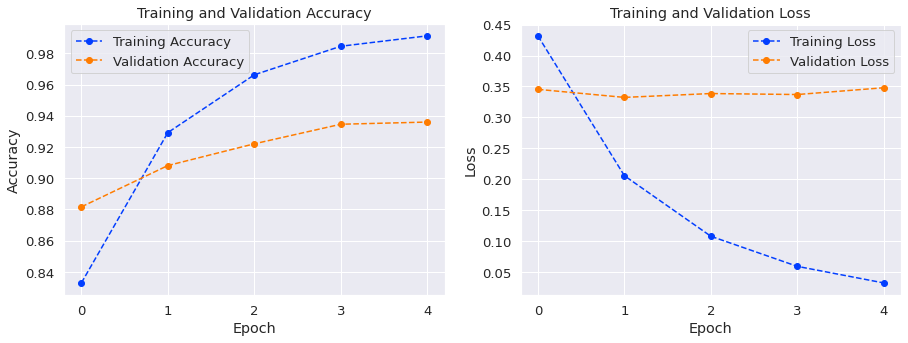

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(history_cpu_train_acc,
             'o--',
             label='Training Accuracy'
             )
axes[0].plot(history_cpu_val_acc,
             'o--',
             label='Validation Accuracy'
             )
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_xticks((0,1,2,3,4))
axes[0].legend(loc='best')

axes[1].plot(history['train_loss'],
             'o--',
             label='Training Loss'
             )
axes[1].plot(history['val_loss'],
             'o--',
             label='Validation Loss'
             )
axes[1].set_title('Training and Validation Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_xticks((0,1,2,3,4))
axes[1].legend(loc='best')

plt.show()

Akurasi pelatihan mulai mendekati 97% setelah 5 epoch. saya mungkin mencoba untuk menyempurnakan parameter sedikit lebih banyak, tetapi ini sudah cukup baik bagi saya.

### Load Pretrained Model

In [50]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### Model Evaluation

In [55]:
test_acc, _ = eval_model(model,
                         test_data_loader,
                         loss_fn,
                         device,
                         len(df_test)
                         )
test_acc.item()

0.9400278940027894

Akurasinya cukup bagus pada set data test. Model membutuhkan penyetelan, saya akan periksa prediksi kembali untuk mendefinisikan fungsi pembantu untuk mendapatkan prediksi terbaik dari model.

In [78]:
def get_predictions(model, data_loader):
  # put model in evaluation mode
  model = model.eval()
  # Create empty lists to store outputs
  review_texts      = []
  predictions       = []
  prediction_probs  = []
  real_values       = []

  with torch.no_grad():
    for batch in data_loader:
        # We'll move the example batch of our test data to the GPU
        texts = batch["review_text"]
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        
        # Perform a forward pass. This will return logits
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask
                        )
        
        # Get the predictions
        _, preds = torch.max(outputs, dim=1)
        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)
        
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities.

In [79]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

Let's have a look at the classification report.

In [80]:
print(classification_report(y_test,
                            y_pred,
                            target_names = class_names))

              precision    recall  f1-score   support

    negative       0.92      0.94      0.93       218
     neutral       0.94      0.92      0.93       208
    positive       0.96      0.95      0.96       291

    accuracy                           0.94       717
   macro avg       0.94      0.94      0.94       717
weighted avg       0.94      0.94      0.94       717



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix-

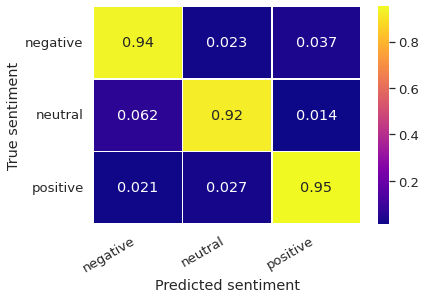

In [81]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, linewidth=.5, annot=True, cmap="plasma")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews.

That's a good overview of the performance of our model. But let's have a look at an example from our test data.

In [93]:
idx = 290
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names,
                        'values': y_pred_probs[idx]
                        })

from textwrap import wrap 
print("\n".join(wrap(review_text)))
print(f'True sentiment: {class_names[true_sentiment]}')

ok game bagus
True sentiment: positive


Now, we can look at the confidence of each sentiment of our mode.

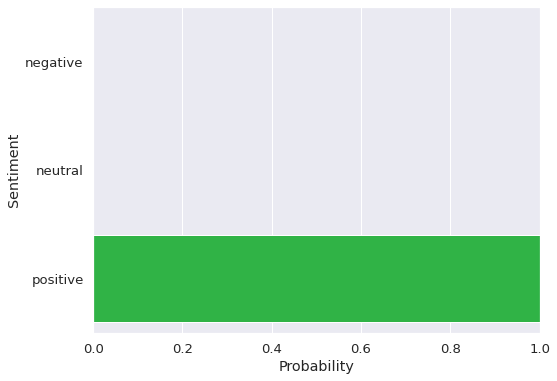

In [94]:
plt.figure(figsize = (8,6))
sns.barplot(x='values',
            y='class_names',
            data=pred_df,
            orient='h'
            )
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1])
plt.show()

### Prediction on Raw Text

In [95]:
def prediction_on_raw_data(raw_text):
  encoded_review = tokenizer.encode_plus(
  raw_text,
  padding='max_length', # Pad sentence to max length
  truncation=True,  #Truncate sentence to max length
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True, # Return attention mask
  return_tensors='pt',  # Return torch objects
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)

  _, prediction = torch.max(output, dim=1)
  
  print(f'Review text: {raw_text}')
  print(f'Sentiment  : {class_names[prediction]}')



In [96]:
# Let's use our model to predict the sentiment of some raw text
raw_text = "aplikasi ini sangat bagus"
prediction_on_raw_data(raw_text)

Review text: aplikasi ini sangat bagus
Sentiment  : positive


In [97]:
raw_text = "game ini banyak bugnya jelek"
prediction_on_raw_data(raw_text)


Review text: game ini banyak bugnya jelek
Sentiment  : negative


In [98]:
raw_text = "tolong perbaiki banyak bug"
prediction_on_raw_data(raw_text)

Review text: tolong perbaiki banyak bug
Sentiment  : neutral
